# Time Series Forecasting 

Generate Data with linear trend with a cyclic pattern and random noise

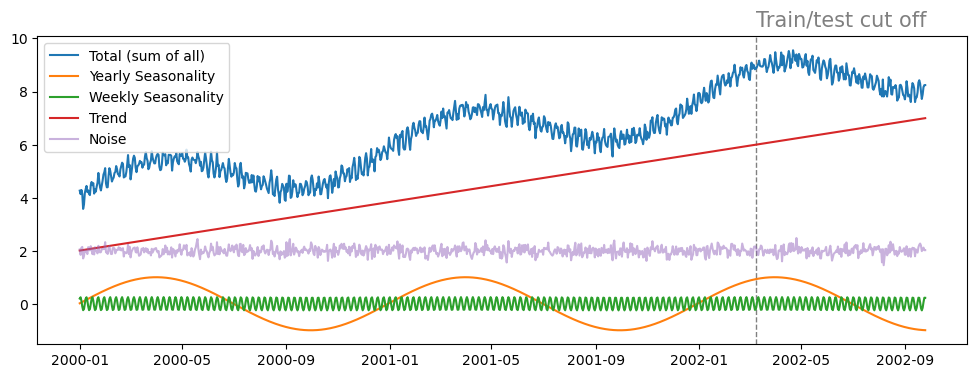

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL, MSTL
import lightgbm as lgb

plt.rcParams['figure.figsize'] = (12, 4)
rng = np.random.default_rng(42)
t = np.arange(1, 1000)
df = pd.DataFrame({
    'yearly_seasonality': np.sin(2*np.pi*t / 365),
    'weekly_seasonality': 0.25*np.sin(2*np.pi*t / 365*52),
    'trend': 2+t*.005,
    'noise': rng.normal(2, scale=0.15, size=len(t)),
},
    index=pd.date_range(start='2000-01-01', periods=len(t), freq='D')
)
df['total'] = df['yearly_seasonality'] + df['weekly_seasonality'] + df['trend'] + df['noise']

train_cutoff = int(len(df) * 0.8)
target_df = df.loc[:, 'total']
train, test = target_df.iloc[:train_cutoff], target_df.iloc[train_cutoff:]

def plot_df(df, train):
    plt.axvline(x=train.index[-1], color='gray', linestyle='--', linewidth=1)
    plt.text(train.index[-1], train.max()+2, 'Train/test cut off',
        color='gray', fontsize=15, va='top', ha='left')

    plt.plot(df['total'], label='Total (sum of all)')
    plt.plot(df['yearly_seasonality'], label='Yearly Seasonality')
    plt.plot(df['weekly_seasonality'], label='Weekly Seasonality')
    plt.plot(df['trend'], label='Trend')
    plt.plot(df['noise'], label='Noise', alpha=.5)
    plt.legend()
    plt.show()

plot_df(df, train)

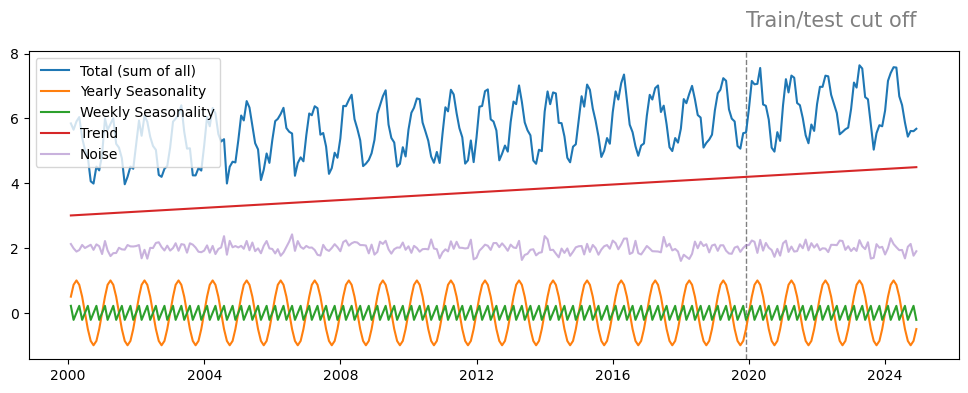

In [3]:
# Resampling was a bit too naive and lost all of the noise in the dataset.
# monthly_df = df.resample('ME').mean().iloc[1:-1] # Remove the first and last points for a pretty plot

t = np.arange(1, 300)
monthly_df = pd.DataFrame({
    'yearly_seasonality': np.sin(2*np.pi*t / 12),
    'weekly_seasonality': 0.25*np.sin(2*np.pi*t / 12*52),
    'trend': 3+t*0.005,
    'noise': rng.normal(2, scale=0.15, size=len(t)),
},
    index=pd.date_range(start='2000-01-01', periods=len(t), freq='ME')
)
monthly_df['total'] = monthly_df['yearly_seasonality'] + monthly_df['weekly_seasonality'] + monthly_df['trend'] + monthly_df['noise']

monthly_train_cutoff = int(len(monthly_df) * 0.8)
monthly_target_df = monthly_df.loc[:, 'total']
monthly_train, monthly_test = monthly_target_df.iloc[:monthly_train_cutoff], monthly_target_df.iloc[monthly_train_cutoff:]

plot_df(monthly_df, monthly_train)

## Stationary
A time series is stationary if it does not exhibit any long term trends or obvious seasonality. It must have:
- constant variance through time
- constant mean through time

Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and so eliminating trends. This can also remove seasonality, if differences are taken appropriately (e.g. differencing observations 1 year apart to remove a yearly trend).

### Augmented Dickey-Fuller
We can use the Augmented Dickey-Fuller (ADF) test to test if the data is stationary. A p-value below 0.05 and a test statistic less than the critical value at the 5% significance level, indicates that the data is stationary at the 5% significance level.

In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

adf_test(train)

print('\nWith differencing:')
adf_test(train.diff().iloc[1:])

Results of Dickey-Fuller Test:
Test Statistic                   0.231933
p-value                          0.973997
#Lags Used                      18.000000
Number of Observations Used    780.000000
Critical Value (1%)             -3.438761
Critical Value (5%)             -2.865253
Critical Value (10%)            -2.568747
dtype: float64

With differencing:
Results of Dickey-Fuller Test:
Test Statistic                  -4.108587
p-value                          0.000937
#Lags Used                      21.000000
Number of Observations Used    776.000000
Critical Value (1%)             -3.438805
Critical Value (5%)             -2.865272
Critical Value (10%)            -2.568757
dtype: float64


### ACF (Autocorrelation Function) 
ACF measures the correlation between the time series and its lagged values. 

ACF is useful for identifying **MA (Moving Average)** components in time series models. If the ACF cuts off after a certain lag (e.g., drops to zero), it suggests that the series can be modeled by an MA process up to that lag.

### PACF (Partial Autocorrelation Function)
PACF measures the correlation between the time series and its lagged values, **but removes the influence of intermediate lags**.

It provides the pure or "partial" correlation at each lag, controlling for the effects of previous lags.

PACF is useful for identifying **AR (Autoregressive)** components. A cut-off in the PACF indicates the order of the AR model to use (i.e., how many past terms are needed to explain the current observation).

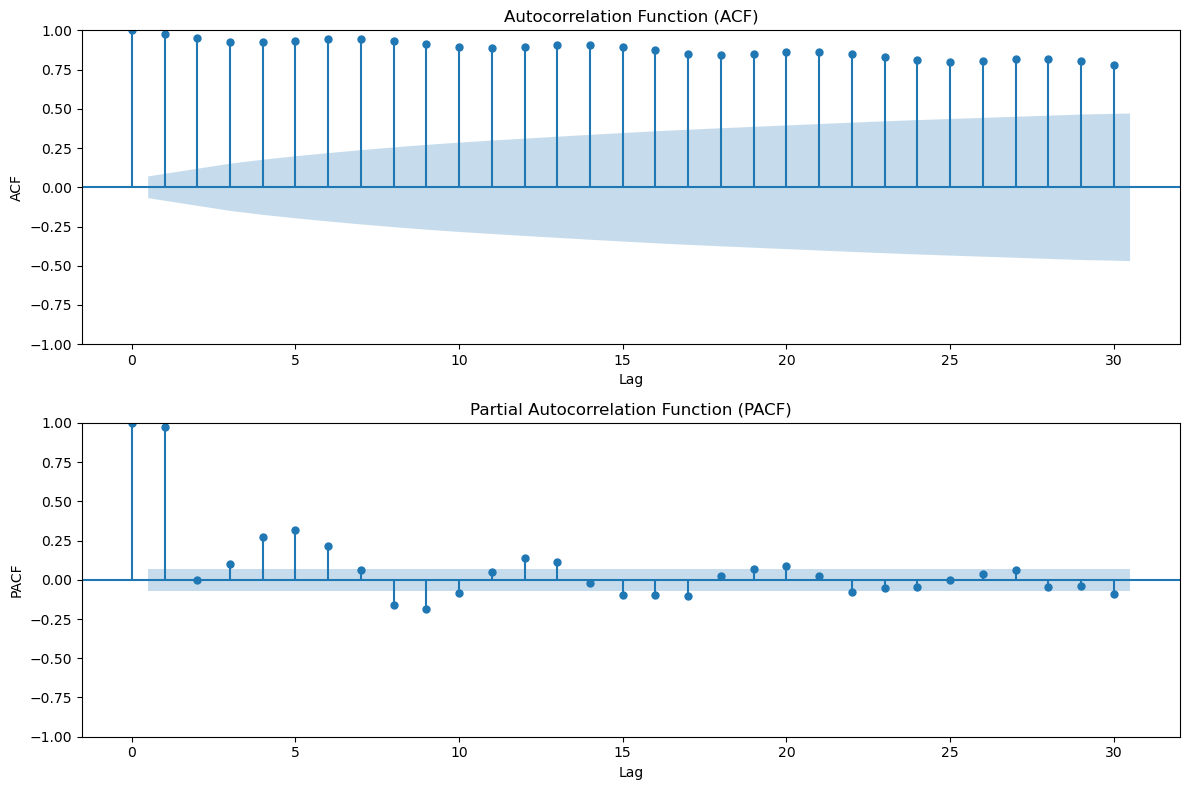

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(train, lags=30, ax=axs[0])
axs[0].set_title('Autocorrelation Function (ACF)')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')

plot_pacf(train, lags=30, ax=axs[1])
axs[1].set_title('Partial Autocorrelation Function (PACF)')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

### Seasonal-Trend decomposition
Just going to demo MSLT below since the example has multiple seasonalities

In [119]:

# stl = STL(train, period=365)
# res = stl.fit()
# fig = res.plot()

### Multiple Seasonal-Trend decomposition [[docs](https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html)]

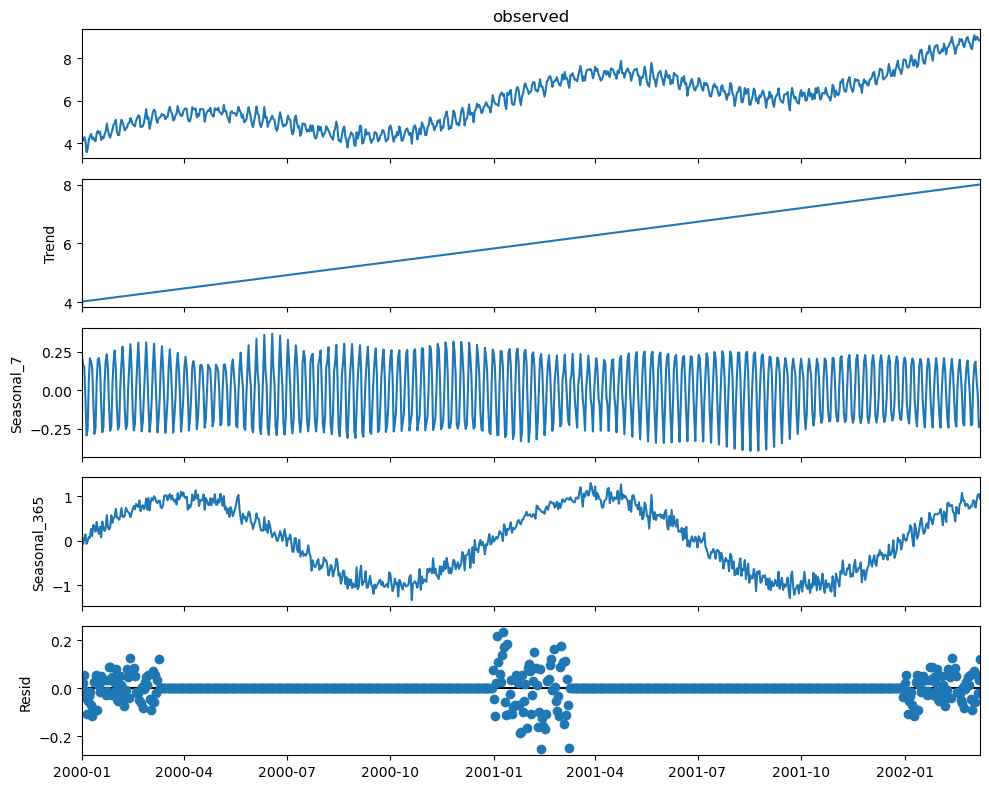

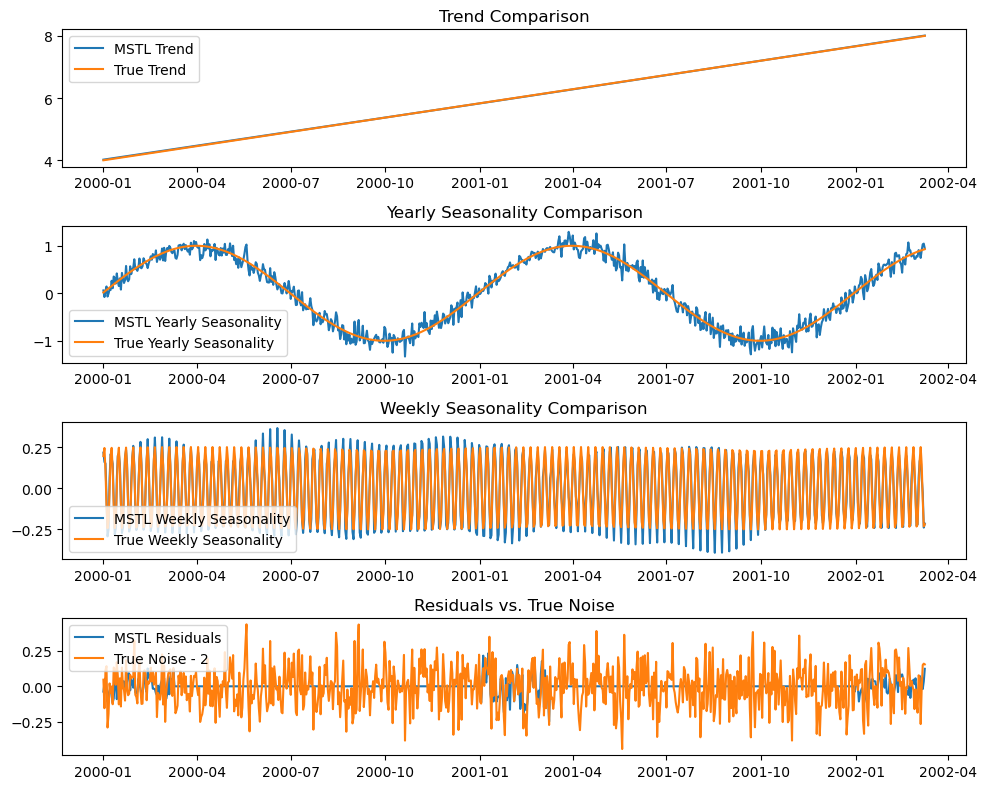

In [120]:
# Update plot size for large graphs
plt.rcParams['figure.figsize'] = (10, 8)
 
mstl = MSTL(train, periods=[7, 365])
res = mstl.fit()
fig = res.plot()

# Plot comparisions
fig, axes = plt.subplots(4, 1)

# Plotting the trend component
axes[0].plot(res.trend, label="MSTL Trend")
axes[0].plot(df.iloc[:len(train)]['trend']+2, label="True Trend")
axes[0].set_title("Trend Comparison")
axes[0].legend()

# Plotting the yearly seasonality component
axes[1].plot(res.seasonal['seasonal_365'], label="MSTL Yearly Seasonality")
axes[1].plot(df.iloc[:len(train)]['yearly_seasonality'], label="True Yearly Seasonality")
axes[1].set_title("Yearly Seasonality Comparison")
axes[1].legend()

# Plotting the weekly seasonality component
axes[2].plot(res.seasonal['seasonal_7'], label="MSTL Weekly Seasonality")
axes[2].plot(df.iloc[:len(train)]['weekly_seasonality'], label="True Weekly Seasonality")
axes[2].set_title("Weekly Seasonality Comparison")
axes[2].legend()

# Plotting the residuals
axes[3].plot(res.resid, label="MSTL Residuals")
axes[3].plot(df.iloc[:len(train)]['noise']-2, label="True Noise - 2")
axes[3].set_title("Residuals vs. True Noise")
axes[3].legend()

plt.tight_layout()
plt.show()

If we take away the noise, the predictions are near perfect

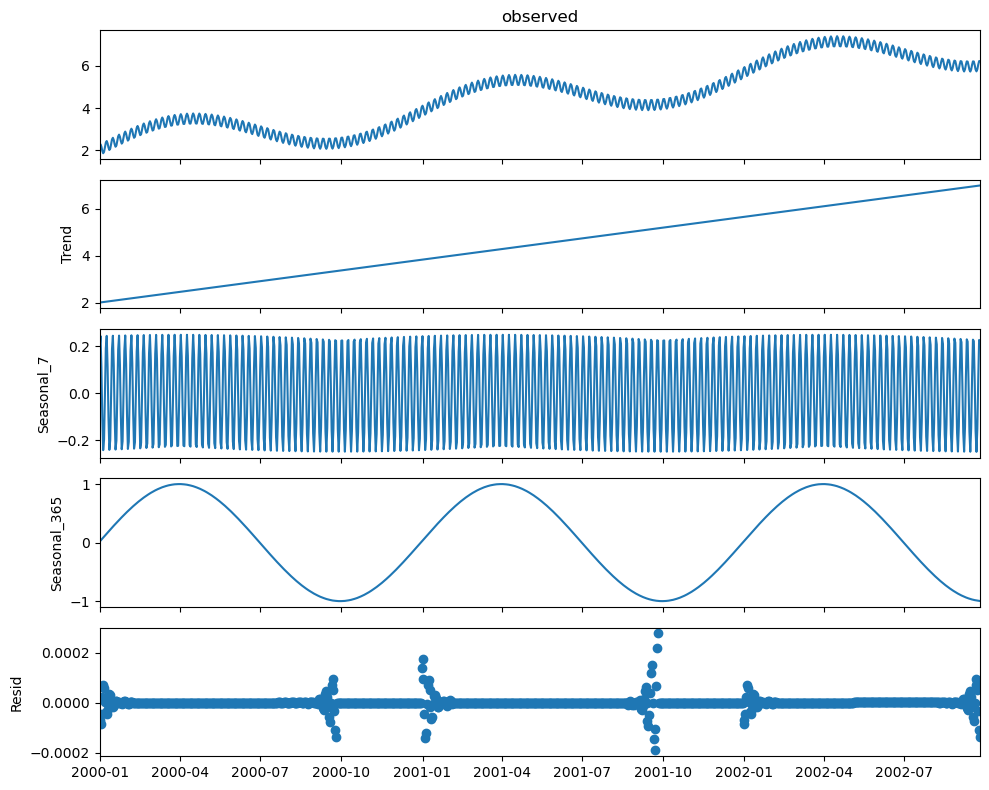

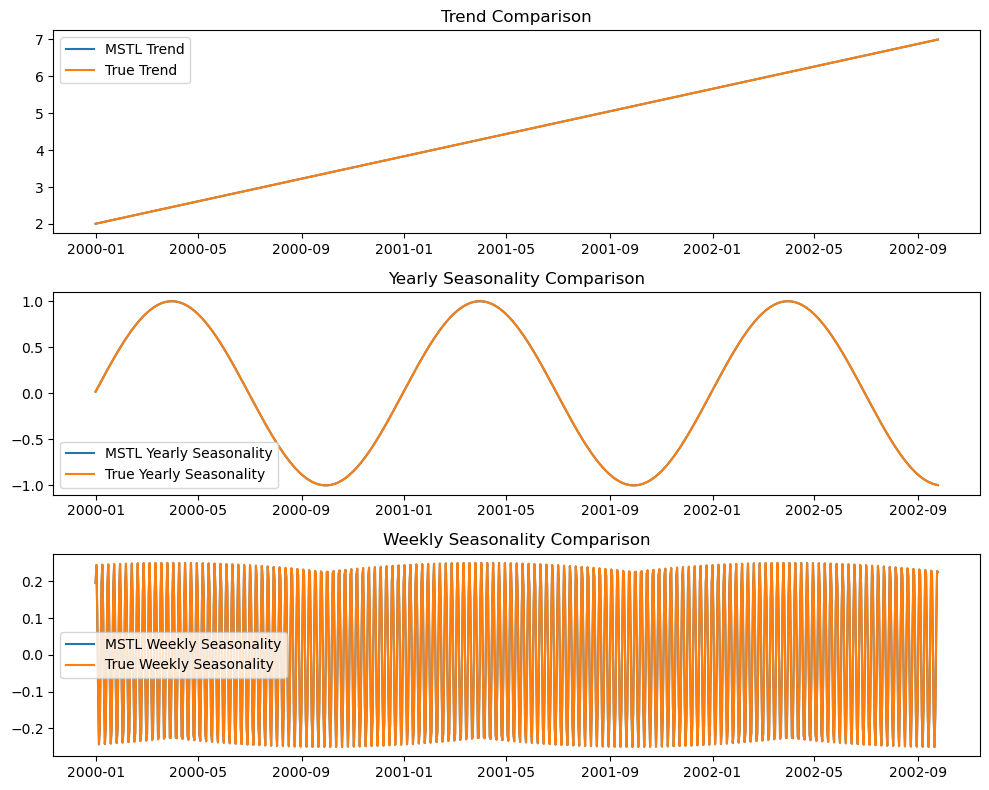

In [121]:
mstl = MSTL(df['total'] - df['noise'], periods=[7, 365])
res = mstl.fit()
fig = res.plot()

# Plot comparisions
fig, axes = plt.subplots(3, 1)

# Plotting the trend component
axes[0].plot(res.trend, label="MSTL Trend")
axes[0].plot(df['trend'], label="True Trend")
axes[0].set_title("Trend Comparison")
axes[0].legend()

# Plotting the yearly seasonality component
axes[1].plot(res.seasonal['seasonal_365'], label="MSTL Yearly Seasonality")
axes[1].plot(df['yearly_seasonality'], label="True Yearly Seasonality")
axes[1].set_title("Yearly Seasonality Comparison")
axes[1].legend()

# Plotting the weekly seasonality component
axes[2].plot(res.seasonal['seasonal_7'], label="MSTL Weekly Seasonality")
axes[2].plot(df['weekly_seasonality'], label="True Weekly Seasonality")
axes[2].set_title("Weekly Seasonality Comparison")
axes[2].legend()

plt.tight_layout()
plt.show()

## Modeling 
### Exponential Smoothing <a name="Exponential-Smoothing"></a>
$ S_t = \alpha  y_t + (1 - \alpha) S_{t-1} $, where
- $ S_t $ is the smoothed value at time $ t $
- $ y_t $ is the actual value at time $ t $
- $ \alpha $ is the smoothing parameter, $ 0 \leq \alpha \leq 1 $

<br>
Simple exponential smoothing won't be able to capture any of the trends on the data :(

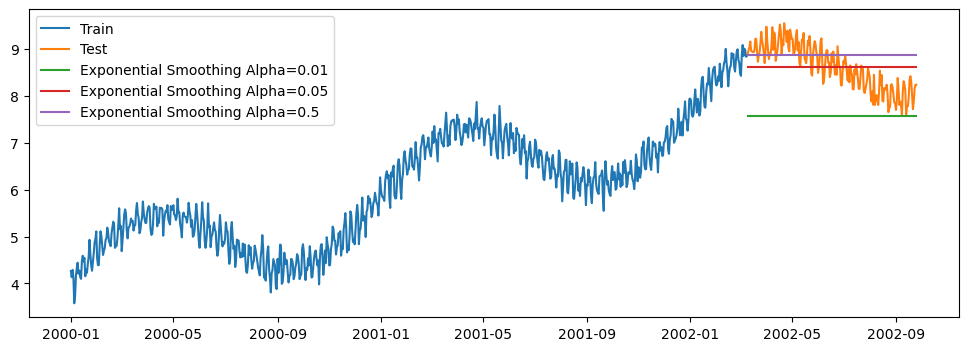

In [169]:
plt.rcParams['figure.figsize'] = (12, 4)

plt.plot(train, label='Train')
plt.plot(test, label='Test')

for alpha in [0.01, 0.05, 0.5]:
    exp_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
    exp_smoothing_forecast = exp_model.forecast(len(test))
    plt.plot(test.index, exp_smoothing_forecast, label=f'Exponential Smoothing Alpha={alpha}')

plt.legend()
plt.show()

#### Exponential smoothing with seasonality (Holt-Winters)


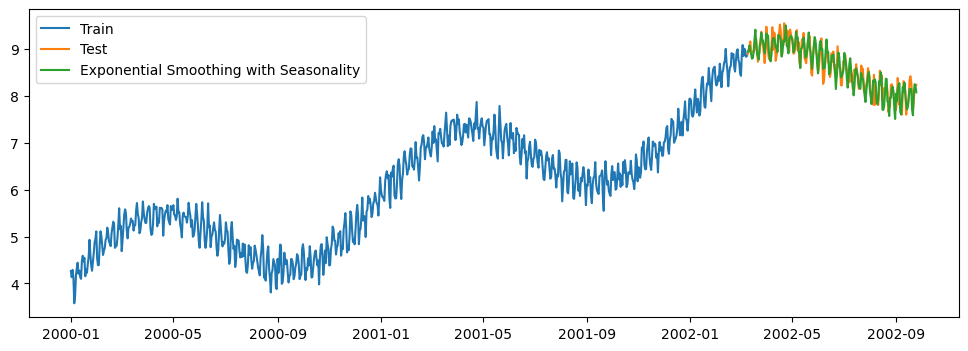

In [161]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')

exp_model = ExponentialSmoothing(
    train,
    seasonal_periods=365,
    trend="add",
    seasonal="add",
).fit()
exp_smoothing_forecast = exp_model.forecast(len(test))

plt.plot(test.index, exp_smoothing_forecast, label=f'Exponential Smoothing with Seasonality')
plt.legend()
plt.show()

#### Model decomposition

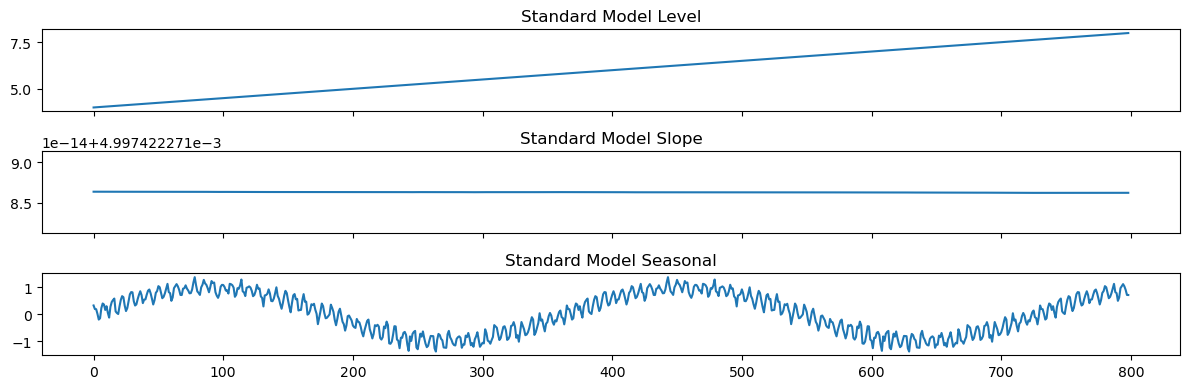

In [163]:
exp_model = ExponentialSmoothing(
    train,
    seasonal_periods=365,
    trend="add",
    seasonal="add"
).fit()

states = pd.DataFrame(
    np.c_[exp_model.level, exp_model.trend, exp_model.season],
    columns=["level", "slope", "seasonal"]
)

fig, axes = plt.subplots(3, 1, sharex=True)
states[["level"]].plot(ax=axes[0], title="Standard Model Level", legend=False)
states[["slope"]].plot(ax=axes[1], title="Standard Model Slope", legend=False)
states[["seasonal"]].plot(ax=axes[2], title="Standard Model Seasonal", legend=False)
plt.tight_layout()
plt.show()

### ARIMA / SARIMAX(p, d, q)x(P, D, Q, s) <a name="ARIMA"></a>

[SARIMAX Examples](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)

[Docs](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html)

Parameters:
* **AutoRegressive (p)**: Relationship between an observation and a certain number of lagged observations (previous time steps). The parameter p determines the number of lag observations included in the model.
* **Integrated (d)**: Order of differencing required to make the series stationary. Differencing is the transformation of a time series to remove trends and seasonality, and d is the number of times the differencing operation is performed.
* **Moving Average (q)**: Relationship between an observation and a residual error from a moving average model applied to lagged observations. The parameter q specifies the number of terms.

Seasonal components:
* **Seasonal AR (P)**: Similar to the AR but apply to the seasonal component of the series. The parameter P specifies the number of seasonal autoregressive terms.
* **Seasonal differencing order (D)**: How many seasonal differences are needed to make the series stationary.
* **Seasonal MA (Q)**: MA for the seasonal differences. Q specifies the number of seasonal moving average terms.
* **Seasonal period (s)**: Length of the seasonal cycle. E.g. s=12 for monthly data with an annual cycle.

Other:
* **Exogenous variables (X)**: External variables that influence the forecast but are not predicted by the model. They can include any variable thought to affect the dependent variable, such as economic indicators, weather conditions, etc.

ARIMA(0,1,1) without constant = simple exponential smoothing


I'm using monthly data here since daily data is impractical for statsmodel's ARIMA to optimize.

c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


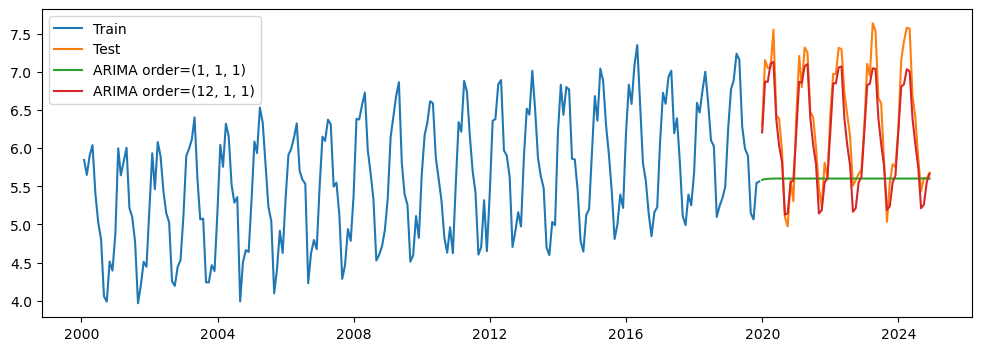

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
warnings.simplefilter('ignore', ConvergenceWarning)

def ARIMA_forecast(model, n_forecast):
    arima_fit = model.fit()
    return arima_fit.forecast(n_forecast)

plt.plot(monthly_train, label='Train')
plt.plot(monthly_test, label='Test')
plt.plot(monthly_test.index, ARIMA_forecast(SARIMAX(monthly_train, order=(1, 1, 1)), len(monthly_test)), label='ARIMA order=(1, 1, 1)')
plt.plot(monthly_test.index, ARIMA_forecast(SARIMAX(monthly_train, order=(12, 1, 1)), len(monthly_test)), label='ARIMA order=(12, 1, 1)')
plt.legend()
plt.show()

c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tested ARIMA(0, 0, 2)x(2, 0, 0, 12) - AIC:-46.64805905208538


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tested ARIMA(1, 0, 0)x(1, 0, 2, 12) - AIC:-41.97098571386274


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tested ARIMA(0, 0, 0)x(2, 0, 1, 24) - AIC:149.8673205869494


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tested ARIMA(0, 1, 2)x(2, 0, 2, 24) - AIC:-96.35801358709928
Tested ARIMA(1, 1, 1)x(0, 0, 0, 24) - AIC:353.0993327804107


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tested ARIMA(1, 0, 1)x(2, 0, 0, 12) - AIC:-87.3921187590398


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tested ARIMA(2, 0, 0)x(0, 0, 1, 24) - AIC:204.2969245925171
Tested ARIMA(1, 1, 0)x(0, 1, 2, 12) - AIC:-118.59164358036283
Tested ARIMA(1, 1, 1)x(1, 1, 2, 12) - AIC:-174.3777714228135
Tested ARIMA(1, 1, 1)x(0, 0, 1, 24) - AIC:170.08863028984462

Best Model: ARIMA(1, 1, 1)x(1, 1, 2, 12) - AIC:-174.3777714228135


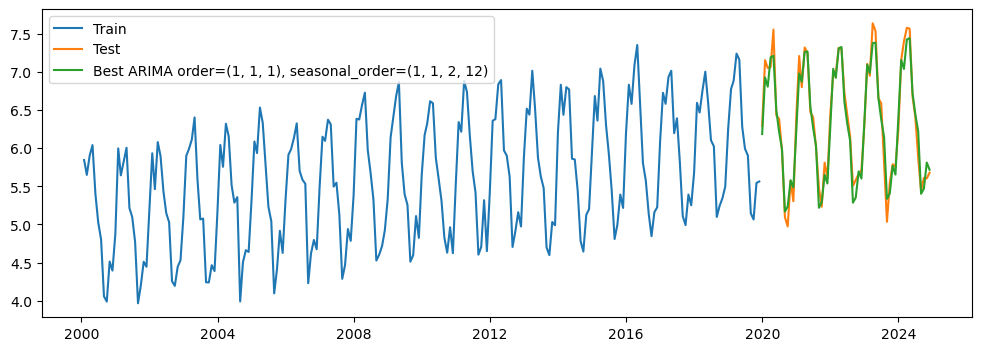

In [19]:
def random_arima_search(train, n_trials=10):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None
    
    # Define search space for (p, d, q) and (P, D, Q, m)
    p_values = range(0, 3)
    d_values = range(0, 2)
    q_values = range(0, 3)
    
    P_values = range(0, 3)
    D_values = range(0, 2)
    Q_values = range(0, 3)
    m_values = [12, 24]  # Seasonal periods to try
    
    for _ in range(n_trials):
        # Randomly select order and seasonal_order
        order = (np.random.choice(p_values), np.random.choice(d_values), np.random.choice(q_values))
        seasonal_order = (np.random.choice(P_values), np.random.choice(D_values), np.random.choice(Q_values), np.random.choice(m_values))
        
        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = model
            
            print(f"Tested ARIMA{order}x{seasonal_order} - AIC:{aic}")
        
        except Exception as e:
            # Handle models that fail to converge or encounter errors
            print(f"Failed for ARIMA{order}x{seasonal_order}: {e}")
    
    print(f"\nBest Model: ARIMA{best_order}x{best_seasonal_order} - AIC:{best_aic}")
    return best_model, best_order, best_seasonal_order

# Perform random search
best_model, best_order, best_seasonal_order = random_arima_search(monthly_train)

plt.plot(monthly_train, label='Train')
plt.plot(monthly_test, label='Test')
plt.plot(monthly_test.index, ARIMA_forecast(best_model, len(monthly_test)), label=f'Best ARIMA order={best_order}, seasonal_order={best_seasonal_order}')
plt.legend()
plt.show()

### LightGBM <a name="lightgbm"></a>
We can turn the forecasting data into tabular form by creating lag features.


```{warning}
Tree based models cannot make predictions outside of the training data. Below we see the result of this by finding that the model won't predict a value higher than what was previously observed.
```
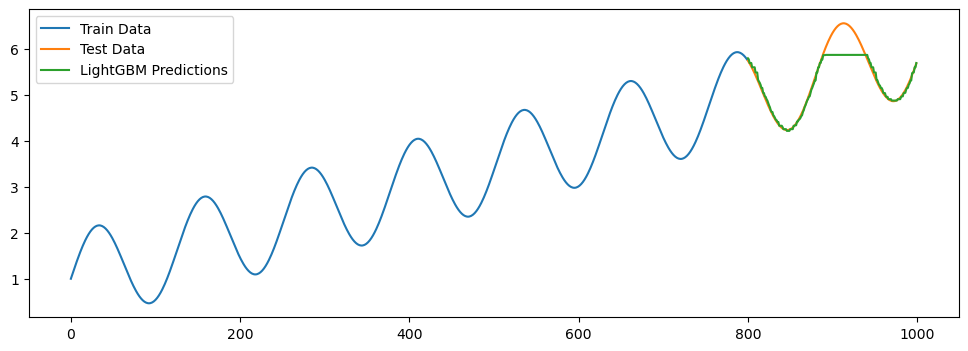

```{figure} ../images/lightgbm_extrapolation.png
:height: 150px
:name: lightgbm_extrapolation

The model will never output 6+ since it hasn't seen that!
```

In [20]:
def load_holidays(start, end):
    ''' USFederalHolidayCalendar is the only calendar that exists and primarily serves as an example for developing other calendars.
        https://pandas.pydata.org/pandas-docs/version/stable/user_guide/timeseries.html'''
    from pandas.tseries.holiday import USFederalHolidayCalendar
    holidays = USFederalHolidayCalendar().holidays(
        start=start,
        end=end, # + pd.DateOffset(weeks=52),
        return_name=True,
    )
    holiday_df = pd.DataFrame(data=holidays, columns=['holiday']).reset_index().rename(columns={'index':'ds'})
    holiday_df['holiday'] = holiday_df['holiday'].astype('category')
    return holiday_df
   
def add_date_features(df):
    df = df.copy() # Create a copy of the DataFrame to avoid modifying the original slice
    df['year'] = df['ds'].dt.year
    df['month'] = df['ds'].dt.month
    df['day_of_week'] = df['ds'].dt.dayofweek
    df['day_of_month'] = df['ds'].dt.day
    df['day_of_year'] = df['ds'].dt.dayofyear
    df['is_month_end'] = df['ds'].dt.is_month_end
    holiday_df = load_holidays(df.ds.min(), df.ds.max())
    return pd.merge(df, holiday_df, how='left', on='ds')

In [49]:
def prep_series_for_gbm(series):
    '''Takes a pandas series (train/test) and outputs X, y'''
    lgb_df = series.to_frame()
    lgb_df = lgb_df.rename(columns={'total': 'y'})
    lgb_df['ds'] = lgb_df.index
    lgb_df = add_date_features(lgb_df)
    X = lgb_df.drop(['y', 'ds'], axis=1)
    y = lgb_df['y']
    return X, y

# for lag in range(1, 5):
#     lgb_train[f't_{lag}'] = lgb_train['y'].shift(lag)

X_train, y_train = prep_series_for_gbm(train)

In [44]:
'''Parameter Tuning'''
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

rng = np.random.default_rng()

param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'metric': ['l2'],
    'learning_rate': rng.uniform(0.01, .5, 10),
    'num_leaves': rng.integers(2, 100, 10),
    'feature_fraction': rng.uniform(0.25, 1, 10),
    'bagging_fraction': rng.uniform(0.25, 1, 10),
    'lambda_l1': rng.uniform(0.0, 0.5, 10),
    'lambda_l2': rng.uniform(0.0, 0.5, 10),
    'min_gain_to_split': rng.uniform(0.01, 0.25, 10),
    'verbose': [-1]
}

gbm = lgb.LGBMRegressor()
grid_search = HalvingRandomSearchCV(estimator=gbm, param_distributions=param_grid, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters found by grid search are:", grid_search.best_params_)

Best parameters found by grid search are: {'verbose': -1, 'num_leaves': 4, 'min_gain_to_split': 0.08150897837565026, 'metric': 'l2', 'learning_rate': 0.27032777573914213, 'lambda_l2': 0.24361348443694952, 'lambda_l1': 0.23935475989654847, 'feature_fraction': 0.27235493395803634, 'boosting_type': 'gbdt', 'bagging_fraction': 0.8165546606798904}


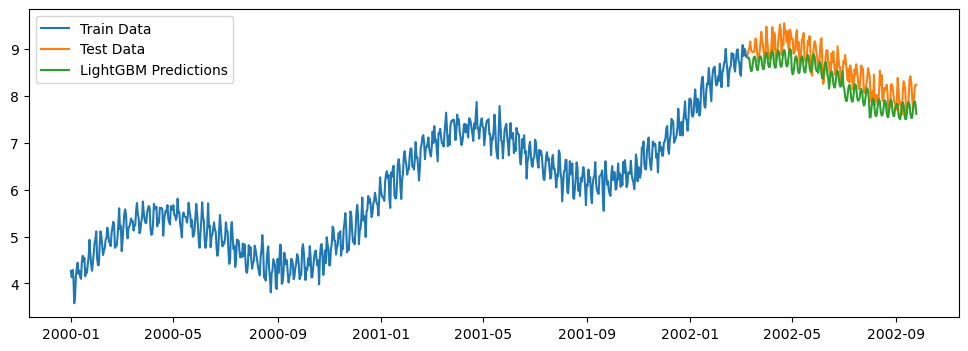

In [50]:
params = grid_search.best_params_ #{'verbose': -1, 'num_leaves': 55, 'min_gain_to_split': 0.06764624350073846, 'metric': 'l2', 'learning_rate': 0.32486093534861593, 'lambda_l2': 0.35299651007555277, 'lambda_l1': 0.10706850623011366, 'feature_fraction': 0.8261402761937192, 'boosting_type': 'gbdt', 'bagging_fraction': 0.843250629681239}
gbm = lgb.train(params, lgb.Dataset(X_train, y_train))

X_test, y_test = prep_series_for_gbm(test)
pred = gbm.predict(X_test)

plt.plot(train, label='Train Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(test.index, pred, label=f'LightGBM Predictions')
plt.legend()
plt.show()

Detrending the training data

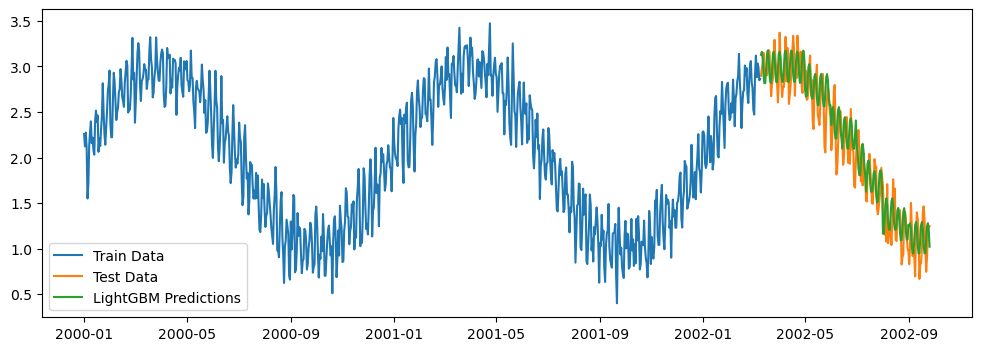

In [64]:
def prep_df_for_gbm(df):
    '''Takes a pandas dataframe (train/test) and outputs X, y'''
    lgb_df = df.rename(columns={0: 'y'})
    lgb_df['ds'] = lgb_df.index
    lgb_df = add_date_features(lgb_df)
    X = lgb_df.drop(['y', 'ds'], axis=1)
    y = lgb_df['y']
    return X, y

lgb_train = (train - df.iloc[:len(train)]['trend']).to_frame()
lgb_test = (test - df.iloc[len(train):]['trend']).to_frame()

X_train, y_train = prep_df_for_gbm(lgb_train)
X_test, y_test = prep_df_for_gbm(lgb_test)

params = grid_search.best_params_ 
gbm = lgb.train(params, lgb.Dataset(X_train, y_train))

X_test, y_test = prep_series_for_gbm(test)
pred = gbm.predict(X_test)

plt.plot(lgb_train, label='Train Data')
plt.plot(lgb_test, label='Test Data')
plt.plot(test.index, pred, label=f'LightGBM Predictions')
plt.legend()
plt.show()

If you also take away the noise, you'll see that LightGBM did a pretty great job filtering it out.

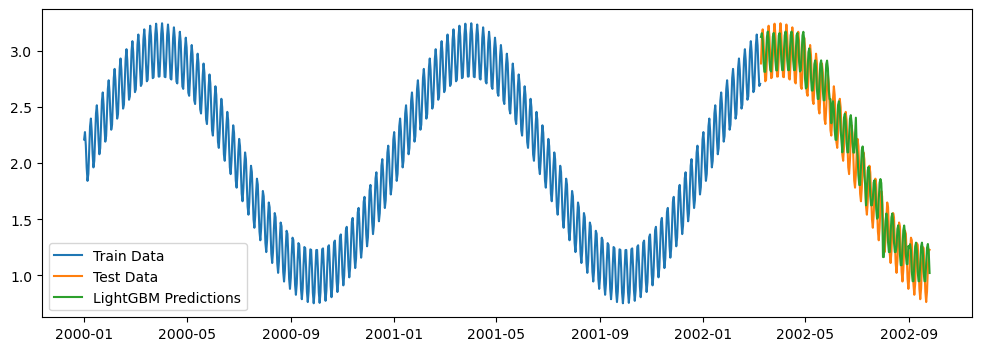

In [73]:
plt.plot(lgb_train[0] - df.iloc[:len(train)]['noise'] + 2, label='Train Data')
plt.plot(lgb_test[0]- df.iloc[len(train):]['noise']+2, label='Test Data')
plt.plot(test.index, pred, label=f'LightGBM Predictions')
plt.legend()
plt.show()

Recursive predictions

In [65]:
# params = grid_search.best_params_ #{'verbose': -1, 'num_leaves': 55, 'min_gain_to_split': 0.06764624350073846, 'metric': 'l2', 'learning_rate': 0.32486093534861593, 'lambda_l2': 0.35299651007555277, 'lambda_l1': 0.10706850623011366, 'feature_fraction': 0.8261402761937192, 'boosting_type': 'gbdt', 'bagging_fraction': 0.843250629681239}
# gbm = lgb.train(params, lgb.Dataset(X, y))

# X_test = pd.DataFrame(index=test.index)  # Create an empty DataFrame for test features
# for lag in range(1, 5):
#     X_test[f't_{lag}'] = 0.0  # Initialize the lag columns for the test data

# # Fill the initial lag values in the test dataframe based on the last values in the training data
# last_train_values = lgb_train.iloc[-1][['t_1', 't_2', 't_3', 't_4']].values
# X_test.iloc[0, :] = last_train_values

# predictions = []

# # Recursive prediction for len(test) iterations
# for i, ds in enumerate(test.index):
#     X_test['ds'] = ds
#     X_test = add_date_features(X_test)
#     # Make a prediction for the current test instance
#     pred = gbm.predict(X_test.iloc[[i]].drop(columns=['ds']))[0]
#     predictions.append(pred)
    
#     # Prepare the next row of X_test by shifting the lag values
#     if i + 1 < len(test):
#         X_test.iloc[i + 1, 1:] = X_test.iloc[i, :-1].values  # Shift the lag features
#         X_test.iloc[i + 1, 0] = pred  # Add the new prediction as the most recent lag feature

# # Convert predictions list to a pandas series to plot
# predictions_series = pd.Series(predictions, index=test.index)

# plt.plot(train, label='Train Data')
# plt.plot(test.index, test, label='Test Data')
# plt.plot(test.index, predictions, label=f'LightGBM Predictions')
# plt.legend()
# plt.show()

## Matrix Profiles  <a name="Matrix-Profiles"></a>
* [Stumpy Documentation](https://stumpy.readthedocs.io/en/latest/#)
* [10 Things to Do with Matrix Profiles](https://www.cs.ucr.edu/~eamonn/Top_Ten_Things_Matrix_Profile.pdf)

The idea here is that we find the nearest neighbor in the time series based on euclidean distance. We split the data into "windows" that are just smaller chunks of data. For example, if you had daily data and wanted to compare weekly trends, you'd use a window of size 7.

The lowest values are considered a motif (pattern) since they represent the pair of nearest neighbor subsequences with the smallest z-normalized Euclidean distance.

The subsequences that have the highest local values are unique.

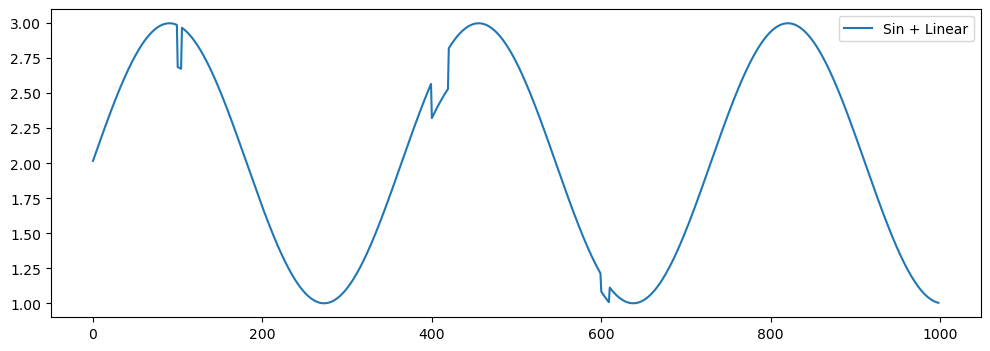

,matrix_profile,indices,left_indices,right_indices
0,0.000004,365,-1,365
1,0.000004,366,-1,366
2,0.000004,367,-1,367
3,0.000004,368,0,368
4,0.000004,369,1,369


In [158]:
import stumpy
from matplotlib.patches import Rectangle

# Removing the date index and adding +2 for easier plotting
anomoly_data = df['yearly_seasonality'].reset_index(drop=True)+2
# Adding some anomolies 
for start, end in [(100, 105), (400, 420), (600, 610)]:
    anomoly_data[start:end] = anomoly_data[start:end] * 0.9

plt.plot(anomoly_data, label='Sin + Linear')
plt.legend()
plt.show()

m = 7
matrix_profile = stumpy.stump(anomoly_data, m=m) 

'''
matrix_profile contains 4 columns:
    1. matrix profile, 
    2. matrix profile indices, 
    3. left matrix profile indices, 
    4. right matrix profile indices.
'''

mp_df = pd.DataFrame({
    "matrix_profile": matrix_profile[:,0],
    "indices": matrix_profile[:,1],
    "left_indices": matrix_profile[:,2],
    "right_indices": matrix_profile[:,3]
})
mp_df.head()

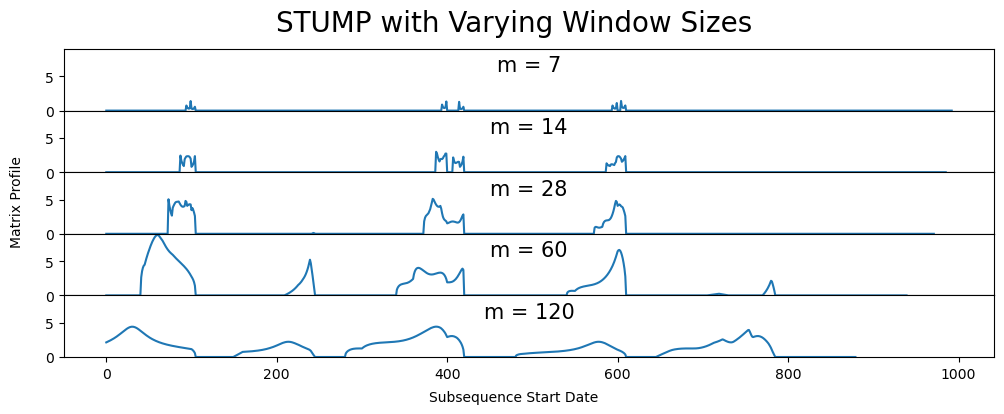

In [206]:
fig, axs = plt.subplots(5, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('STUMP with Varying Window Sizes', fontsize='20')
fig.text(0.5, 0, 'Subsequence Start Date', ha='center', fontsize='10')
fig.text(0.08, 0.5, 'Matrix Profile', va='center', rotation='vertical', fontsize='10')
for i, varying_m in enumerate([7, 14, 28, 60, 120]):
    mp = stumpy.stump(anomoly_data, m=varying_m)
    axs[i].plot(mp[:, 0])
    axs[i].set_ylim(0, 9)
    title = f"m = {varying_m}"
    axs[i].set_title(title, fontsize=15, y=.5)

### Motif / Pattern
The matrix profile allows you to find patterns and also the nearest neighbor for all subsequences.

The motif is located at index 903
The nearest neighbor is located at index 173


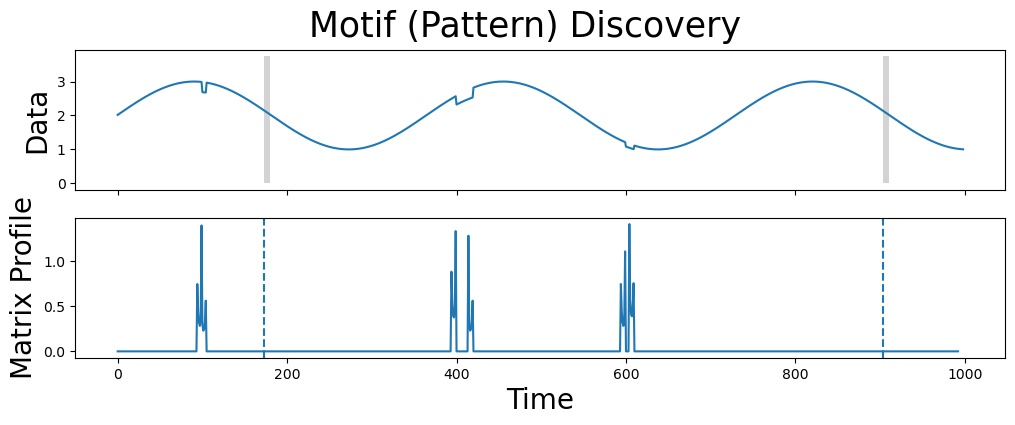

In [159]:
motif_idx = np.argsort(matrix_profile[:, 0])[0]
print(f"The motif is located at index {motif_idx}")

nearest_neighbor_idx = matrix_profile[motif_idx, 1]
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

fig, axs = plt.subplots(2, figsize=(12, 4), sharex=True)
plt.suptitle('Motif (Pattern) Discovery', fontsize='25')
axs[0].plot(anomoly_data)
axs[0].add_patch(Rectangle((motif_idx, 0), m, anomoly_data.max()*1.25, facecolor='lightgrey'))
axs[0].add_patch(Rectangle((nearest_neighbor_idx, 0), m, anomoly_data.max()*1.25, facecolor='lightgrey'))
axs[0].set_ylabel('Data', fontsize='20')
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(matrix_profile[:, 0])
plt.show()

### Potential Anomolies
The subsequence located at this global maximum is referred to as a discord, novelty, or potential anomaly.

The discord is located at index 604
The nearest neighbor subsequence to this discord is 1.406757555930853 units away


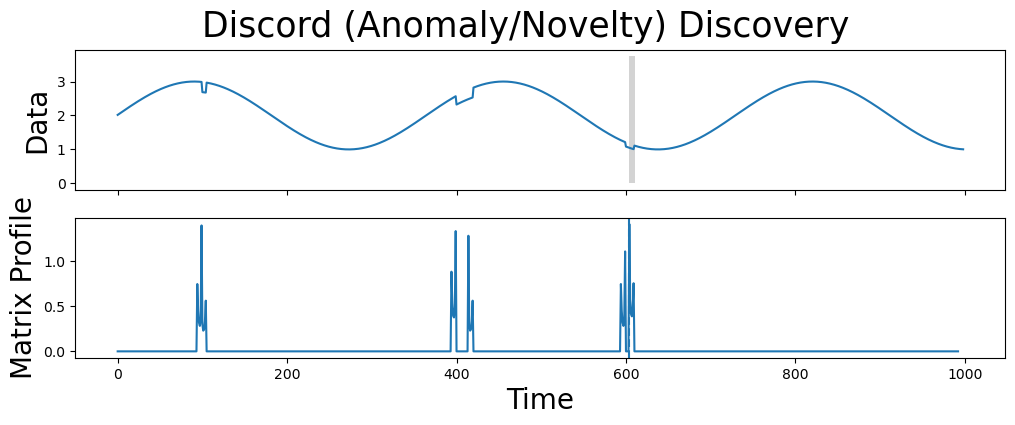

In [160]:
discord_idx = np.argsort(matrix_profile[:, 0])[-1]
print(f"The discord is located at index {discord_idx}")

nearest_neighbor_distance = matrix_profile[discord_idx, 0]
print(f"The nearest neighbor subsequence to this discord is {nearest_neighbor_distance} units away")

fig, axs = plt.subplots(2, figsize=(12, 4), sharex=True)
plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='25')
axs[0].plot(anomoly_data)
axs[0].set_ylabel('Data', fontsize='20')
axs[0].add_patch(Rectangle((discord_idx, 0), m, anomoly_data.max()*1.25, facecolor='lightgrey'))
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=discord_idx, linestyle="dashed")
axs[1].plot(matrix_profile[:, 0])
plt.show()

## Box-Cox Transformation <a name="box-cox"></a>
Transforms the target variable so that data resembles a normal distribution which is assumed by many models.

Cons:
* Harder to interprete
* Usually gives the median of the forecast distribution when we revert the transformed data to its original scale.

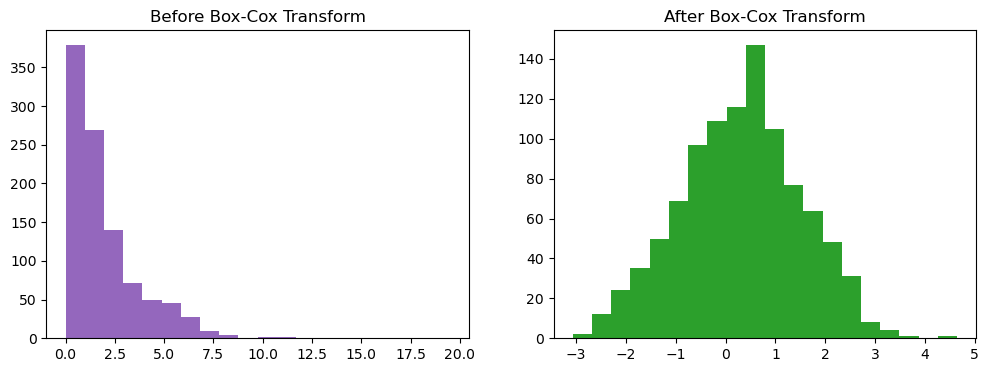

In [167]:
data = rng.exponential(scale=2, size=1000)
transformed_data, lambda_best = stats.boxcox(data)

plt.subplot(1, 2, 1)
plt.hist(data, bins=20, color='tab:purple')
plt.title("Before Box-Cox Transform")

plt.subplot(1, 2, 2)
plt.hist(transformed_data, bins=20, color='tab:green')
plt.title("After Box-Cox Transform")
plt.show()

## Portmanteau Test <a name="Portmanteau-Test"></a>
Hypothesis test for the presence of autocorrelation. 

## Ljung-Box Test
[Ljung-Box test of autocorrelation in residuals](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html) is commonly applied to the residuals of a time series model, such as ARIMA or other time series models, to test whether they are independent (i.e., no autocorrelation remains in the residuals).

A p-value is greater than 0.05 implies that no significant autocorrelation remains in the residuals, and the model is a good fit from the perspective of autocorrelation.

In [172]:
ljung_box_result = acorr_ljungbox(train, lags=[7, 14, 365], return_df=True)

'''
acorr_ljungbox outputs:
- lb_stat: The Ljung-Box test statistic.
- lb_pvalue: The p-value associated with the test statistic. A small p-value indicates that significant autocorrelation exists at the tested lags.
'''
print(ljung_box_result)

          lb_stat  lb_pvalue
7     5004.563971        0.0
14    9648.760599        0.0
365  43432.463826        0.0


## References
* [Forecasting: Principles and Practice](https://otexts.com/fpp3/)
* [ARIMA models for time series forecasting](https://people.duke.edu/~rnau/411arim.htm#pdq)
* [statsmodels.org](https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html)
* [LightGBM](https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html)